<a href="https://colab.research.google.com/github/ganagashekar/STOCKS_MAIN/blob/main/BankOptions_Automatic_working_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# uncomment for google colab
#test
!pip install ta
!pip install pykalman
!pip install pandas-datareader
!pip install pandas
!pip install matplotlib
!pip install fast-ta
!pip install yfinance
!pip install mplfinance

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
!pip install mibian
!pip install vectorbt
#uncomment this partb'.
import talib
!pip install ta
!pip install breeze-connect
import vectorbt as vbt
import ta
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from breeze_connect import BreezeConnect
import sys
import bisect
import datetime
#import mibian   #to easily calculate iv and greeks  (not the fastest way though)
import logging
from IPython.display import clear_output
import dateutil.parser
from google.colab import files
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
sns.set()
# More Plotting libaries
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# libraries for Data Download
import datetime
from pandas_datareader import data as pdr
import yfinance as yf

clear_output(wait=False)

In [ ]:
api_key = "6N4Hj74vE@668970816zP9K307YZ58Ff"
api_secret = "iz1F27815220!290Ie8Ha459997J8376"
api_session = '48938079'
app = BreezeConnect(api_key=api_key)
app.generate_session(api_secret=api_secret,
                     session_token=api_session)
clear_output(wait=False)
from_date= "2024-11-07T09:00:00.000Z"
to_date= "2024-11-07T16:55:00.000Z"
SavingFilenames=datetime.datetime.strptime(from_date.split('T')[0], '%Y-%m-%d')


In [ ]:
from google.colab import drive
import random
drive.mount('/content/drive', force_remount=True)
global DF_Sample;
global testk;
testk=0
OptionName='NIFTY'
fixed_digits = 6


Mounted at /content/drive


To use STOCH RSI instead of Money Flow Index:

In [ ]:
"""
Source for this STOCH RSI: (closest i could find to tradingview.com)
https://gist.github.com/ultragtx/6831eb04dfe9e6ff50d0f334bdcb847d
"""
#data = get_indicators(df)
logfilename=datetime.datetime.strptime(from_date.split('T')[0], '%Y-%m-%d')
logging.basicConfig(filename='/content/drive/MyDrive/colab/NIFTY/'+str(logfilename)+'_app.log',
                    level=logging.INFO,
                    force=True, # Resets any previous configuration
                    )
# def Log(Filenames):
# Filenames=datetime.datetime.strptime(from_date.split('T')[0], '%Y-%m-%d')
# logging.basicConfig(filename='/content/drive/MyDrive/colab/BANKNIFTY/'+ str(Filenames)+'app.log',
#                     level=logging.INFO,
#                     force=True, # Resets any previous configuration
#                     )
logging.info('this is a debug message')

def StochRSI(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean()
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.rolling(smoothK).mean()
    stochrsi_D = stochrsi_K.rolling(smoothD).mean()

    return stochrsi_K, stochrsi_D

def StochRSI_EMA(series, period=14, smoothK=3, smoothD=3):
    # Calculate RSI
    delta = series.diff().dropna()
    ups = delta * 0
    downs = ups.copy()
    ups[delta > 0] = delta[delta > 0]
    downs[delta < 0] = -delta[delta < 0]
    ups[ups.index[period-1]] = np.mean( ups[:period] ) #first value is sum of avg gains
    ups = ups.drop(ups.index[:(period-1)])
    downs[downs.index[period-1]] = np.mean( downs[:period] ) #first value is sum of avg losses
    downs = downs.drop(downs.index[:(period-1)])
    rs = ups.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean() / \
         downs.ewm(com=period-1,min_periods=0,adjust=False,ignore_na=False).mean()
    rsi = 100 - 100 / (1 + rs)

    # Calculate StochRSI
    stochrsi  = (rsi - rsi.rolling(period).min()) / (rsi.rolling(period).max() - rsi.rolling(period).min())
    stochrsi_K = stochrsi.ewm(span=smoothK).mean()
    stochrsi_D = stochrsi_K.ewm(span=smoothD).mean()

    return stochrsi_K, stochrsi_D

def plot_chart(data, n,m,i, ticker): # add i here for the gif script

    # Filter number of observations to plot
    data = data.iloc[n:m,:]

    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))

    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_VWAP = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_PS = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_CCI = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_MFI = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    # adx_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)

    # Format x-axis ticks as dates
    ax_candle.xaxis_date()

    # Get nested list of date, open, high, low and close prices
    ohlc = []
    i=0;
    for date, row in data.iterrows():
        #print(i)
        # print(row[6])
        # print(row[4])
        # print(row[5])
        # print(row[0])
        #openp, highp, lowp, closep = row[:4]
        #crtime=datetime.datetime.strptime(row[1], '%Y-%m-%d %H:%M:%S.%f')
        ohlc.append([ i, float(row[6]), float(row[4]), float(row[5]), float(row[0])])
        i = i + 1


    # Plot candlestick chart
    ax_candle.plot(data.index, data["EMA50"], label="EMA50",c = '#4d00ff')
    ax_candle.plot(data.index, data["EMA100"], label="EMA100",c = '#9001f0')
    ax_candle.plot(data.index, data["EMA200"], label="EMA200",c = '#d102e8')
    ax_candle.plot(data.index, data["EMA300"], label="EMA300",c = '#f101c2')
    ax_candle.plot(data.index, data['VWAP'], label='Volume Weighted Average Price', c='#4d00ff', alpha = 0.7)
    ax_candle.plot(data.index, data["MA200"], label="MA200",c = '#e80030', alpha = 0.3)
    ax_candle.plot(data.index, data["MA5"], label="MA5",c = '#ff5400', alpha = 0.3)
    ax_candle.plot(data.index, data["MA10"], label="MA10",c = '#9e0059', alpha = 0.3)
    ax_candle.plot(data.index, data["MA300"], label="MA300",c = '#f101c2', alpha = 0.3)
    ax_candle.plot(data.index, data["upperband"], label = 'Upper BB', c= '#22223b', alpha = 0.7)
    ax_candle.plot(data.index, data["middleband"], label = 'Middle BB', c= '#4a4e69',linestyle='--')
    ax_candle.plot(data.index, data["lowerband"], label = 'Lower BB', c= '#22223b', alpha = 0.7)
    ax_candle.fill_between(data.index, data["upperband"], data["lowerband"], color= '#22223b', alpha = 0.05)
    candlestick_ohlc(ax_candle, ohlc, colorup="#00f5d4", colordown="#ef233c", width=0.8)
    ax_candle.plot(data.index, data['Buy_Signal'], '^', markersize=10, color='#013220')
    ax_candle.plot(data.index, data['Sell_Signal'], 'v', markersize=10, color='#960018')
    ax_candle.set_ylabel(f"{ticker} Daily Candle Stick")
    ax_candle.legend()

    # Plot MACD
    ax_macd.plot(data.index, data["macd"], label="MACD", c = '#22223b')
    ax_macd.plot(data.index, data["macd_EMA50"], label="MACD EMA 50", c = '#22223b', alpha = 0.7)
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist", color = '#22223b', alpha = 0.7)
    ax_macd.plot(data.index, data["macd_signal"], label="signal", c = '#ef233c')
    ax_macd.fill_between(data.index, data["macd"], data["macd_EMA50"], where=(data["macd"] > data["macd_EMA50"]), color= '#00f5d4', alpha = 0.05)
    ax_macd.fill_between(data.index, data["macd_signal"], data["macd_EMA50"], where=(data["macd_signal"] > data["macd_EMA50"]) ,color= '#00f5d4', alpha = 0.05)
    ax_macd.fill_between(data.index, data["macd"], data["macd_EMA50"], where=(data["macd"] < data["macd_EMA50"]), color= '#ef233c', alpha = 0.05)
    ax_macd.fill_between(data.index, data["macd_signal"], data["macd_EMA50"], where=(data["macd_signal"] < data["macd_EMA50"]) ,color= '#ef233c', alpha = 0.05)
    ax_macd.plot(data.index, data['macd_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_macd.plot(data.index, data['macd_sell_signal'], 'v', markersize=10, color='#960018')
    ax_macd.set_ylabel("Moving Average Convergence Divergence")
    ax_macd.legend()

    # Pattern Score
    ax_PS.plot(data.index, [100] * len(data.index),c = '#22223b')
    ax_PS.plot(data.index, [0] * len(data.index), c = '#22223b',linestyle='--')
    ax_PS.plot(data.index, [-100] * len(data.index),c = '#22223b')
    ax_PS.plot(data.index, data['pattern_score'], label="Pattern Score", c='#22223b',alpha = 0.7)
    ax_PS.plot(data.index, data['pattern_score'].ewm(span=10).mean(), label="Pattern Score EMA10", c='#ef233c',alpha = 0.7)
    ax_PS.set_ylabel("Pattern Score")
    ax_PS.legend()

    # Plot CCI
    ax_CCI.plot(data.index, [100] * len(data.index),c = '#22223b')
    ax_CCI.plot(data.index, [0] * len(data.index), c = '#22223b',linestyle='--')
    ax_CCI.plot(data.index, [-100] * len(data.index),c = '#22223b')
    ax_CCI.fill_between(data.index, data["CCI"], [-100]*len(data.index), where=(data["CCI"] < [-100]*len(data.index)), color= '#ef233c', alpha = 0.1)
    ax_CCI.fill_between(data.index, data["CCI"], [100]*len(data.index), where=(data["CCI"] > [100]*len(data.index)), color= '#00f5d4', alpha = 0.1)
    ax_CCI.plot(data.index, data["CCI"], label="Commodity Channel Index", c='#ef233c',alpha = 0.7)
    # ax_CCI.plot(data.index, data['Volume_pct']*100000,label="Volume Scaled Rate of Change", c = '#22223b', alpha = 0.1  )
    ax_CCI.plot(data.index, data['CCI_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_CCI.plot(data.index, data['CCI_sell_signal'], 'v', markersize=10, color='#960018')
    ax_CCI.set_ylabel("Commodity Channel Index")
    ax_CCI.legend()

    # Volume on same axis
    ax_vol.bar(data.index, data["volume"] / 1000000, color = '#22223b', alpha = 0.25)
    ax_vol.set_ylabel("Volume Millions")
    ax_vol.grid(False)


    # adx_vol.bar(data.index, data["volume"] / 1000000, color = '#22223b', alpha = 0.25)
    # adx_vol.set_ylabel("ADX")
    # adx_vol.grid(True)

    # STOCH RSI
    ax_RSI=ax_vol.twinx()
    ax_RSI.plot(data.index, data['stochrsi_K']*100, label="RSI K%", c = '#22223b', alpha = 0.7)
    ax_RSI.plot(data.index, data['stochrsi_D']*100, label="RSI D%", c = '#ef233c', alpha = 0.7)
    ax_RSI.plot(data.index, data['stochrsi_K_EMA50']*100, label="RSI EMA50", c = '#22223b', alpha = 0.5)
    ax_RSI.fill_between(data.index, data['stochrsi_K_EMA50']*100, data['stochrsi_K']*100, where=(data['stochrsi_K']*100 > data['stochrsi_K_EMA50']*100), color= '#00f5d4', alpha = 0.05)
    ax_RSI.fill_between(data.index, data['stochrsi_K_EMA50']*100, data['stochrsi_K']*100, where=(data['stochrsi_K']*100 < data['stochrsi_K_EMA50']*100), color= '#ef233c', alpha = 0.05)
    ax_RSI.plot(data.index, [80] * len(data.index),c = '#22223b')
    ax_RSI.plot(data.index, [20] * len(data.index),c = '#22223b')
    ax_RSI.plot(data.index, data['RSI_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_RSI.plot(data.index, data['RSI_sell_signal'], 'v', markersize=10, color='#960018')
    ax_RSI.set_ylabel("Stochastic RSI")
    ax_RSI.legend()

    # Money Flow Index
    # ax_MFI=ax_vol.twinx()
    ax_MFI.plot(data.index, [20] * len(data.index),c = '#22223b')
    ax_MFI.plot(data.index, data['Mean_Center_MFI'], c = '#22223b', label = "Mean Center MFI",alpha = 0.7) # Change these to stoch
    ax_MFI.plot(data.index, [0] * len(data.index), c = '#22223b',linestyle='--')
    ax_MFI.plot(data.index, data['EMA50_Mean_Center_MFI'], c = '#ef233c', label = "MFI EMA50",alpha = 0.7)
    ax_MFI.plot(data.index, [-20] * len(data.index),c = '#22223b')
    ax_MFI.plot(data.index, data['MFI_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_MFI.plot(data.index, data['MFI_sell_signal'], 'v', markersize=10, color='#960018')
    ax_MFI.set_ylabel("Money Flow Index")
    ax_MFI.legend()

    # # VWAP & EMAs
    ax_VWAP=ax_vol.twinx() # change this based on which you want to show with it
    ax_VWAP.plot(data.index, data['VWAP'], label='Volume Weighted Average Price', c='#22223b', alpha = 1)
    ax_VWAP.plot(data.index, data['EMA9'], label='EMA9', c='#ef233c',alpha = 0.333 )
    ax_VWAP.plot(data.index, data['EMA50'], label='EMA50', c='#ef233c', alpha = 0.666)
    ax_VWAP.plot(data.index, data["MA200"], label="MA200",c = '#ef233c', alpha = 1)
    ax_VWAP.fill_between(data.index, data['EMA9'], data['EMA50'], where=(data['EMA9'] > data['EMA50']), color= '#00f5d4', alpha = 0.02)
    ax_VWAP.fill_between(data.index, data['EMA9'], data['MA200'], where=(data['EMA9'] > data['MA200']), color= '#00f5d4', alpha = 0.02)
    ax_VWAP.fill_between(data.index, data['MA200'], data['EMA50'], where=(data['EMA50'] > data['MA200']), color= '#00f5d4', alpha = 0.02)
    ax_VWAP.fill_between(data.index, data['EMA9'], data['EMA50'], where=(data['EMA9'] < data['EMA50']), color= '#ef233c', alpha = 0.02)
    ax_VWAP.fill_between(data.index, data['EMA9'], data['MA200'], where=(data['EMA9'] < data['MA200']), color= '#ef233c', alpha = 0.02)
    ax_VWAP.fill_between(data.index, data['MA200'], data['EMA50'], where=(data['EMA50'] < data['MA200']), color= '#ef233c', alpha = 0.02)
    ax_VWAP.plot(data.index, data['VWAP_buy_signal'], '^', markersize=10, color='#59cd90')
    ax_VWAP.plot(data.index, data['VWAP_sell_signal'], 'v', markersize=10, color='#960018')
    ax_VWAP.set_ylabel("Volume Weighted Average Price")
    ax_VWAP.legend()

    # To save save the chart as PNG
    # fig.savefig(str(ticker) + str(i) + ".png", bbox_inches="tight")
    # from google.colab import files
    # files.download( str(ticker) + str(i) + ".png" )
    #clear_output(wait=False)
    fig.savefig('/content/drive/MyDrive/colab/data2_filtered'+str(SavingFilenames)+'.png', bbox_inches='tight')
    plt.show()

def get_indicators(data):

    data = data[data['volume'] != 0]
    # df.reset_index(drop=True, inplace=True)
    data.isna().sum()
    data.head(10)

    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    # ema10 works well for crypto
    data['macd_signal'] = data['macd_signal'].ewm(span=10).mean()
    data['macd_EMA50'] = data['macd'].ewm(span=50).mean()
    data['macd_hist'] = data['macd_hist'].ewm(span=10).mean()
    data['macd_signal_s1'] = data['macd_signal'].shift(1)
    data['macd_s1'] = data['macd'].shift(1)
    data['macd_hist_s1'] = data['macd_hist'].shift(1)
    data['macd_hist_s2'] = data['macd_hist'].shift(2)
    data['macd_hist_s3'] = data['macd_hist'].shift(3)

    # Get EMAs and MAs
    data['EMA9'] = data['close'].ewm(span=9).mean()
    data['EMA9_s1'] = data['EMA9'].shift(1)
    data['EMA5'] = data['close'].ewm(span=5).mean()
    data['EMA10'] = data['close'].ewm(span=10).mean()
    data['EMA50'] = data['close'].ewm(span=50).mean()
    data['EMA50_s1'] = data['EMA50'].shift(1)
    data['EMA100'] = data['close'].ewm(span=100).mean()
    data['EMA200'] = data['close'].ewm(span=200).mean()
    data['EMA300'] = data['close'].ewm(span=300).mean()

    data['MA200'] = data['close'].rolling(window=200).mean()
    data['MA5'] = data['close'].rolling(window=5).mean()
    data['MA5_s1'] = data['MA5'].shift(1)
    data['MA10'] = data['close'].rolling(window=10).mean()
    data['MA300'] = data['close'].rolling(window=300).mean()
    data['MA10_s1'] = data['MA10'].shift(1)

    data['MA50'] = data['close'].rolling(window=50).mean()

    # CCI
    data["CCI"] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=20)
    data["CCI_s1"] = data["CCI"].shift(1)

    # # Money flow index 14
    data['Money_flow_index14'] = ta.volume.money_flow_index(data['high'], data['low'], data['close'],data['volume'], 14 , fillna =False)
    # Mean centered money flow index
    data['Mean_Center_MFI'] = data['Money_flow_index14'] - data['Money_flow_index14'].rolling(200, min_periods=20).mean()
    data['EMA50_Mean_Center_MFI'] = data['Mean_Center_MFI'].ewm(span=50).mean()

    # BB
    data["upperband"], data["middleband"], data["lowerband"] = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    ## FULL STO
    data['stochrsi_K'], data['stochrsi_D'] = StochRSI_EMA(data['close'], period=14, smoothK=3, smoothD=3)
    data['stochrsi_K_s1'] = data['stochrsi_K'].shift(1)
    data['stochrsi_D_s1'] = data['stochrsi_D'].shift(1)
    data['stochrsi_K_EMA50'] = data['stochrsi_K'].ewm(span=50).mean()
    data['stochrsi_K_EMA50_s1'] = data['stochrsi_K_EMA50'].shift(1)

    # Volume
    data['Volume_s1'] = data['volume'].shift(1)
    data['volume_pct'] = np.log(data['volume']).pct_change().ewm(span=50).mean() # percentage change
    data['Volume_pct_s1'] = data['volume_pct'].shift(1)

    # Volume weighted average price
    data['VWAP'] = np.cumsum(data['volume']*(data['high']+data['low'])/2) / np.cumsum(data['volume'])
    data['VWAP_s1'] = data['VWAP'].shift(1)

    # Previous Candle
    data['High_s1'] = data['high'].shift(1)
    data['Low_s1'] = data['low'].shift(1)
    data['Open_s1'] = data['open'].shift(1)
    data['Close_s1'] = data['close'].shift(1)

    data['High_s2'] = data['high'].shift(2)
    data['Low_s2'] = data['low'].shift(2)
    data['Open_s2'] = data['open'].shift(2)
    data['Close_s2'] = data['close'].shift(2)

    return data

def patterns(data):
  high = data['high']
  low = data['low']
  open = data['open']
  close= data['close']

  data['1'] = talib.CDL2CROWS(open, high, low, close)
  data['2'] = talib.CDL3BLACKCROWS(open, high, low, close)
  data['3'] = talib.CDL3INSIDE(open, high, low, close)
  data['4'] = talib.CDL3LINESTRIKE(open, high, low, close)
  data['5'] = talib.CDL3OUTSIDE(open, high, low, close)
  data['6'] = talib.CDL3STARSINSOUTH(open, high, low, close)
  data['7'] = talib.CDL3WHITESOLDIERS(open, high, low, close)
  data['8'] = talib.CDLABANDONEDBABY(open, high, low, close, penetration=0)
  data['9'] = talib.CDLADVANCEBLOCK(open, high, low, close)
  data['10'] = talib.CDLBELTHOLD(open, high, low, close)
  data['11'] = talib.CDLBREAKAWAY(open, high, low, close)
  data['12'] = talib.CDLCLOSINGMARUBOZU(open, high, low, close)
  data['13'] = talib.CDLCONCEALBABYSWALL(open, high, low, close)
  data['14'] = talib.CDLCOUNTERATTACK(open, high, low, close)
  data['15'] = talib.CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
  data['16'] = talib.CDLDOJI(open, high, low, close)
  data['17'] = talib.CDLDOJISTAR(open, high, low, close)
  data['18'] = talib.CDLDRAGONFLYDOJI(open, high, low, close)
  data['19'] = talib.CDLENGULFING(open, high, low, close)
  data['20'] = talib.CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
  data['21'] = talib.CDLEVENINGSTAR(open, high, low, close, penetration=0)
  data['22'] = talib.CDLGAPSIDESIDEWHITE(open, high, low, close)
  data['23'] = talib.CDLGRAVESTONEDOJI(open, high, low, close)
  data['24'] = talib.CDLHAMMER(open, high, low, close)
  data['25'] = talib.CDLHANGINGMAN(open, high, low, close)
  data['26'] = talib.CDLHARAMI(open, high, low, close)
  data['27'] = talib.CDLHARAMICROSS(open, high, low, close)
  data['28'] = talib.CDLHIGHWAVE(open, high, low, close)
  data['29'] = talib.CDLHIKKAKE(open, high, low, close)
  data['30'] = talib.CDLHIKKAKEMOD(open, high, low, close)
  data['31'] = talib.CDLHOMINGPIGEON(open, high, low, close)
  data['32'] = talib.CDLIDENTICAL3CROWS(open, high, low, close)
  data['33'] = talib.CDLINNECK(open, high, low, close)
  data['34'] = talib.CDLINVERTEDHAMMER(open, high, low, close)
  data['35'] = talib.CDLKICKING(open, high, low, close)
  data['36'] = talib.CDLKICKINGBYLENGTH(open, high, low, close)
  data['37'] = talib.CDLLADDERBOTTOM(open, high, low, close)
  data['38'] = talib.CDLLONGLEGGEDDOJI(open, high, low, close)
  data['39'] = talib.CDLLONGLINE(open, high, low, close)
  data['40'] = talib.CDLMARUBOZU(open, high, low, close)
  data['41'] = talib.CDLMATCHINGLOW(open, high, low, close)
  data['42'] = talib.CDLMATHOLD(open, high, low, close, penetration=0)
  data['43'] = talib.CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
  data['44'] = talib.CDLMORNINGSTAR(open, high, low, close, penetration=0)
  data['45'] = talib.CDLONNECK(open, high, low, close)
  data['46'] = talib.CDLPIERCING(open, high, low, close)
  data['47'] = talib.CDLRICKSHAWMAN(open, high, low, close)
  data['48'] = talib.CDLRISEFALL3METHODS(open, high, low, close)
  data['49'] = talib.CDLSEPARATINGLINES(open, high, low, close)
  data['50'] = talib.CDLSHOOTINGSTAR(open, high, low, close)
  data['51'] = talib.CDLSHORTLINE(open, high, low, close)
  data['52'] = talib.CDLSPINNINGTOP(open, high, low, close)
  data['53'] = talib.CDLSTALLEDPATTERN(open, high, low, close)
  data['54'] = talib.CDLSTICKSANDWICH(open, high, low, close)
  data['55'] = talib.CDLTAKURI(open, high, low, close)
  data['56'] = talib.CDLTASUKIGAP(open, high, low, close)
  data['57'] = talib.CDLTHRUSTING(open, high, low, close)
  data['58'] = talib.CDLTRISTAR(open, high, low, close)
  data['59'] = talib.CDLUNIQUE3RIVER(open, high, low, close)
  data['60'] = talib.CDLUPSIDEGAP2CROWS(open, high, low, close)
  data['61'] = talib.CDLXSIDEGAP3METHODS(open, high, low, close)
  data['pattern_score'] = data.loc[:, '1':'61'].sum(axis=1)

  return data

def buy_conditions(s):

    # Pattern Score
    if (s['19'] >= 100) and (s['close'] < s['MA300']):
      return s['close']
    if (s['24'] >= 100) and (s['close'] < s['MA300']):
      return s['close']
    if (s['48'] >= 100):
      return s['close']
    if (s['46'] >= 100) and (s['close'] < s['MA300']):
      return s['close']

    # MACD
    if (s['macd_signal_s1'] > s['macd_s1']) and (s['macd'] > s['macd_signal']):
      return s['close']
    if (s['macd_hist'] < 0) and (s['macd_hist_s3'] < s['macd_hist_s2'] < s['macd_hist_s1'] <s['macd_hist']) and (s['close'] < s['MA200']):
      return s['close']

    if (s['macd_hist'] < 0) and (s['macd_hist_s3'] < s['macd_hist_s2'] < s['macd_hist_s1'] <s['macd_hist']) and \
    (s['close'] > s['MA200']) and (s['open'] < s['MA5']):
      return s['close']

    # STOCH RSI
    if (s['stochrsi_K_EMA50_s1'] > s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] < s['stochrsi_K']) and (s['stochrsi_K_EMA50'] < 0.3):
            return s['close']

    # EMA
    if (s['EMA9_s1'] < s['EMA50_s1']) and (s['EMA9'] > s['EMA50']) and (s['close'] < s['MA200']):
      return s['close']

    # CCI
    if (s['close'] < s['MA200']):
      if (s['CCI_s1'] < 0) and (s['CCI'] > 0):
        return s['close']

    if (s['CCI'] < -250) and (s['close'] < s['MA200']):
        return s['close']
    else:
        return None # Do Nothing


def sell_conditions(s):

    # Pattern Score
    if (s['26'] <= -100) and (s['close'] > s['MA300']):
      return s['close']
    if (s['15'] <= -100) and (s['close'] > s['MA300']):
      return s['close']
    if (s['21'] <= -100) and (s['close'] > s['MA200']):
      return s['close']
    if (s['25'] <= -100) and (s['close'] > s['MA300']):
      return s['close']


    if (s['MA5_s1'] > s['MA10_s1']) and (s['MA5'] < s['MA10']) and (s['MA200'] < s['close'] ):
      return s['close']

    # MACD
    if (s['macd_signal_s1'] < s['macd_s1']) and (s['macd'] < s['macd_signal']) and (s['close'] > s['MA200']):
          return s['close']
    if (s['macd_hist'] > 0) and (s['macd_hist_s3'] > s['macd_hist_s2'] > s['macd_hist_s1'] > s['macd_hist']) and (s['close'] > s['MA200']):
      return s['close']

    if (s['macd_hist'] > 0) and (s['macd_hist_s3'] > s['macd_hist_s2'] > s['macd_hist_s1'] > s['macd_hist']) and \
    (s['close'] < s['MA200']) and (s['middleband'] > s['close']):
      return s['close']

    # STOCH RSI
    if (s['stochrsi_K_EMA50_s1'] < s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] > s['stochrsi_K'])  and (s['stochrsi_K_EMA50'] > 0.7):
            return s['close']

    # EMA
    if (s['open'] > s['upperband']) and (s['close'] > s['upperband']) and (s['close'] > s['EMA50'] ):
      return s['close']
    if (s['EMA9_s1'] > s['EMA50_s1']) and (s['EMA9'] < s['EMA50']) and (s['close'] > s['MA200']):
      return s['close']

    # CCI
    if (s['CCI_s1'] > 0) and (s['CCI'] < 0) and (s['macd_signal'] > s['macd']) and (s['close'] > s['MA200']):
        return s['close']

    if (s['CCI'] > 200) and (s['close'] > s['MA200']):
        return s['close']

    else:
        return None # Do Nothing


def macd_buy_signal(s):
    if (s['macd_signal_s1'] > s['macd_s1']) and (s['macd'] > s['macd_signal']):
      return s['macd']
    # if (s['macd_hist'] < 0) and (s['macd_hist_s3'] < s['macd_hist_s2'] < s['macd_hist_s1'] <s['macd_hist']) and \
    # (s['close'] < s['MA200']):  # add dont buy if greater than upppband
    #   return s['macd']
    else:
        return None # Do Nothing

def macd_sell_signal(s):
    if (s['macd_signal_s1'] < s['macd_s1']) and (s['macd'] < s['macd_signal']):
      return s['macd']
    # if (s['macd_hist'] > 0) and (s['macd_hist_s3'] > s['macd_hist_s2'] > s['macd_hist_s1'] > s['macd_hist']) and \
    #  (s['EMA5'] > s['EMA10']):
    #   return s['macd']
    else:
        return None # Do Nothing

def cci_buy_signal(s):
    if (s['CCI_s1'] < 0) and (s['CCI'] > 0):
      return s['CCI']
    else:
        return None # Do Nothing

def cci_sell_signal(s):
    if (s['CCI_s1'] > 0) and (s['CCI'] < 0):
      return s['CCI']
    else:
        return None # Do Nothing

def rsi_buy_signal(s):
    if (s['stochrsi_K_EMA50_s1'] > s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] < s['stochrsi_K']):
      return s['stochrsi_K_EMA50']*100
    else:
        return None # Do Nothing

def rsi_sell_signal(s):
    if (s['stochrsi_K_EMA50_s1'] < s['stochrsi_K_s1']) and (s['stochrsi_K_EMA50'] > s['stochrsi_K']):
      return s['stochrsi_K_EMA50']*100
    else:
        return None # Do Nothing

def vwap_buy_signal(s):
    # if (s['EMA9_s1'] < s['VWAP_s1']) and (s['EMA9'] > s['VWAP']):
    #   return s['EMA9']
    if (s['EMA9_s1'] < s['EMA50_s1']) and (s['EMA9'] > s['EMA50']) and (s['close'] < s['MA200']):
      return s['EMA9']

    else:
        return None # Do Nothing

def vwap_sell_signal(s):
    # if (s['EMA9_s1'] > s['VWAP_s1']) and (s['EMA9'] < s['VWAP']):
    #   return s['EMA9']
    if (s['EMA9_s1'] > s['EMA50_s1']) and (s['EMA9'] < s['EMA50']) and (s['close'] > s['MA200']):
      return s['EMA9']
    else:
        return None # Do Nothing

# CHANGE TO MFI AND BUY AND SELL AT EMA50 TOUCHING -20 20
# turn this into when ema50 crosses the mfi above -+19
def MFI_buy_signal(s):
    if (s['EMA50_Mean_Center_MFI'] < -20) :
      return s['EMA50_Mean_Center_MFI']
    else:
        return None # Do Nothing

def MFI_sell_signal(s):
    if (s['EMA50_Mean_Center_MFI'] > 20):
      return s['EMA50_Mean_Center_MFI']
    else:
        return None # Do Nothing

Alter buy and sell conditions to try different strategies

In [ ]:
listOfOrder = []
class Orders:

    # init method or constructor
    def __init__(self,stock_code,exchange_code,action,order_type,quantity,OrderPrice,
               expiry_date,strike_price,right_action,product_type,call_orderId,put_orderId,IsBuyExecuted,IsSellExecuted,IsOrderPlaced,livePrice,PreviousPivotDate):
        self.stock_code = stock_code
        self.exchange_code = exchange_code
        self.action = action
        self.order_type = order_type
        self.quantity = quantity
        self.OrderPrice = OrderPrice
        self.expiry_date = expiry_date
        self.strike_price = strike_price
        self.right_action = right_action
        self.product_type = product_type
        self.call_orderId = call_orderId
        self.put_orderId = put_orderId
        self.IsBuyExecuted = IsBuyExecuted
        self.IsSellExecuted = IsSellExecuted
        self.livePrice = livePrice
        self.PreviousPivotDate = PreviousPivotDate

    # Sample Method
    def say_hi(self):
        print('Hello, my name is', self.name)
    def cancelOrder(self,app):
        print('cancelOrder at  '+ str(self.OrderPrice) + 'Order Id' + str(self.orderId))
        cancel_order=app.cancel_order(exchange_code=str(self.exchange_code),order_id= str(self.orderId))
        if(cancel_order['Status']==200):
            self.orderId = 0
            print("Cancel Success Order Id " + str(self.orderId))
            self.IsBuyExecuted=False
            self.IsOrderPlaced=False
            listOfOrder.append(self)
        else:
            print(cancel_order)
            self.IsBuyExecuted=True
            self.IsOrderPlaced=True
        return self

    def PlaceOrder(self,app):
        _fresh_order_id='';
        _IsBuyExecuted=False
        print('Order Price Is ', self.OrderPrice)
        buy_order = app.place_order(stock_code=str(self.stock_code),
                              exchange_code=str(self.exchange_code),
                              product=self.product_type,
                              action=str(self.action),
                              order_type='limit', #str(self.order_type),
                              #stoploss="",
                              quantity= str(self.quantity),
                              #price='0',
                              price=1,
                              validity="day",
                              validity_date='',
                              disclosed_quantity="",
                              expiry_date=str(self.expiry_date),
                              right=self.right_action,
                              user_remark='Test',
                              strike_price=str(self.strike_price))

        #  # #print(buy_order)
        # if(1==0):

        #     if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='put'):
        #         self.put_orderId = 0
        #     if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='call'):
        #         self.call_orderId = 0



        #     if(str(self.action).lower()=='buy' and  str(self.right_action).lower()=='put'):
        #        self.put_orderId = random.randrange(111111, 999999, fixed_digits)
        #     if(str(self.action).lower()=='buy' and  str(self.right_action).lower()=='call'):
        #        self.call_orderId = random.randrange(111111, 999999, fixed_digits)


        #     self.IsBuyExecuted=True
        #     self.IsOrderPlaced=True
        #     listOfOrder.append(self)
        # else:
        #   print(buy_order)


        #print(buy_order)
        logging.info(buy_order)
        if(buy_order['Status']==200):
            if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='put'):
                self.put_orderId = 0
            if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='call'):
                self.call_orderId = 0

            if(str(self.right_action).lower()=='call'):
                self.call_orderId = buy_order["Success"]["order_id"]
            else:
                self.put_orderId = buy_order["Success"]["order_id"]

            self.IsBuyExecuted=True
            self.IsOrderPlaced=True
            listOfOrder.append(self)
        else:
          print(buy_order)

        return self

    def Squareoff(self,app):
        sq_off_order = app.square_off(exchange_code=str(self.exchange_code),
                    product=self.product_type,
                    stock_code=str(self.stock_code),
                    expiry_date=str(self.expiry_date),
                    right=self.right_action,
                    strike_price=str(self.strike_price),
                    action=str(self.action),
                    order_type=str(self.order_type),
                    validity="day",
                    stoploss="",
                    quantity=15,#sum(c.quantity for c in listOfOrder),
                    #quantity=str(self.quantity),
                    #price=0,
                    price=int(self.OrderPrice),
                    validity_date=datetime.datetime.now().strftime('%Y-%m-%dT06:00:00.000Z')  ,
                    trade_password="",
                    disclosed_quantity="0")

        # if(1==0):


        #     if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='put'):
        #         self.put_orderId = 0
        #     if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='call'):
        #         self.call_orderId = 0



        #     if(str(self.action).lower()=='buy' and  str(self.right_action).lower()=='put'):
        #        self.put_orderId = random.randrange(111111, 999999, fixed_digits)
        #     if(str(self.action).lower()=='buy' and  str(self.right_action).lower()=='call'):
        #        self.call_orderId = random.randrange(111111, 999999, fixed_digits)


        #     # if(str(self.right_action).lower()=='call'):
        #     #     self.call_orderId = 0
        #     # else:
        #     #     self.put_orderId = 0
        #     self.IsBuyExecuted=False
        #     self.IsSellExecuted=True
        #     #self.orderId=0
        #     listOfOrder.clear()
        #     return self
        # else:
        #   print(sq_off_order)
        logging.info(sq_off_order)
        if(sq_off_order['Status']==200) :
            if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='put'):
                self.put_orderId = 0
            if(str(self.action).lower()=='sell' and  str(self.right_action).lower()=='call'):
                self.call_orderId = 0
            self.IsBuyExecuted=False
            self.IsSellExecuted=True
            self.orderId=0
            listOfOrder.clear()
        else:
          print(sq_off_order)


        return self

In [ ]:



import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
warnings.simplefilter(action='ignore', category=FutureWarning)
def Execute(ticks,app,from_date,to_date,stock_code,strike_price):
    return GetData(ticks,app,from_date,to_date,stock_code,strike_price)
PreviousPivotDate=''
global k
k=0


def isNaN(num):
    return num != num

def GetBuySingal(data,PreviousPivotDate,df_call_orderId,df_put_orderId,stock_code,strike_price):
  dfpl = data
  # logging.info('START BUY df_call_orderId :' + str (df_call_orderId))
  # logging.info('START BUY df_put_orderId :' + str (df_put_orderId))

  if(len(dfpl)> 0 ):


      pivotpoint=dfpl['close']
      parsed1 = dateutil.parser.parse(str(dfpl['datetime']))
      if(pd.isna(PreviousPivotDate)):
           logging.info('Buy Call ,Buy Method  for '+str(stock_code)+' First Found  Buy Call at=' + str(parsed1)  + "Price =" + str(pivotpoint) + " Live Price="+str(dfpl['close']) )
           order_obj=Orders(stock_code= stock_code,exchange_code=str(dfpl['exchange_code']),action='buy',order_type='limit',quantity=25,OrderPrice=pivotpoint,
                 expiry_date=dfpl['expiry_date'],strike_price=strike_price,right_action='call',product_type=dfpl['product_type'],
                 call_orderId=df_call_orderId,put_orderId=df_put_orderId,IsBuyExecuted=False,IsSellExecuted=False,IsOrderPlaced=False,livePrice=dfpl['close'],PreviousPivotDate=parsed1)
           execute_Order=order_obj.PlaceOrder(app)
           PreviousPivotDate=str(execute_Order.PreviousPivotDate)
          #  logging.info('df_call_orderId :' + str (df_call_orderId))
          #  logging.info('df_put_orderId :' + str (df_put_orderId))
           return execute_Order

      if pd.isna(PreviousPivotDate)==False:
          if not isinstance(PreviousPivotDate, pd.Timestamp):
              previous_date = dateutil.parser.parse(str(PreviousPivotDate)) # Parse only if it's a string.
          else:
              previous_date = PreviousPivotDate # If it's a Timestamp, use it directly.
          if(parsed1 > previous_date) :

            if(int(df_put_orderId)>0):
               logging.info('Sell Put ,Buy Method  for '+str(stock_code)+' Second Found  Sell PUT at=' + str(parsed1)  + "Price =" + str(pivotpoint) + " Live Price="+str(dfpl['close']) )
               order_obj=Orders(stock_code= stock_code,exchange_code=str(dfpl['exchange_code']),action='sell',order_type='limit',quantity=25,OrderPrice=pivotpoint,
               expiry_date=dfpl['expiry_date'],strike_price=strike_price,right_action='put',product_type=dfpl['product_type'],
               call_orderId=df_call_orderId,put_orderId=df_put_orderId,IsBuyExecuted=False,IsSellExecuted=False,IsOrderPlaced=False,livePrice=dfpl['close'],PreviousPivotDate=parsed1)
               execute_Order=order_obj.PlaceOrder(app)
               PreviousPivotDate=(execute_Order.PreviousPivotDate)
               df_put_orderId = 0
               execute_Order.df_put_orderId = 0



            logging.info('Buy Call ,Buy Method  for '+str(stock_code)+' Second Found  Buy Call at=' + str(parsed1)  + "Price =" + str(pivotpoint) + " Live Price="+str(dfpl['close']) )

            order_obj=Orders(stock_code= stock_code,exchange_code=str(dfpl['exchange_code']),action='buy',order_type='limit',quantity=25,OrderPrice=pivotpoint,
                  expiry_date=dfpl['expiry_date'],strike_price=strike_price,right_action='call',product_type=dfpl['product_type'],
                  call_orderId=df_call_orderId,put_orderId=df_put_orderId,IsBuyExecuted=False,IsSellExecuted=False,IsOrderPlaced=False,livePrice=dfpl['close'],PreviousPivotDate=parsed1)
            execute_Order=order_obj.PlaceOrder(app)
            PreviousPivotDate=(execute_Order.PreviousPivotDate)
            # logging.info('df_call_orderId :' + str (df_call_orderId))
            # logging.info('df_put_orderId :' + str (df_put_orderId))
            #print(int(df_put_orderId))

            return execute_Order
      else:
          return None

def GetSellSingal(data,PreviousPivotDate,df_call_orderId,df_put_orderId,stock_code,strike_price):
  # logging.info('START SELL df_call_orderId :' + str (df_call_orderId))
  # logging.info('START SELL df_put_orderId :' + str (df_put_orderId))
  dfpl = data
  if(len(dfpl)> 0 ):
     if(1==1):
        #dfpl.to_csv('../df2.csv')
        pivotpoint=dfpl['close']
        #print('pivotpoint'+ str(pivotpoint))
        parsed1 = dateutil.parser.parse(str(dfpl['datetime']))

        if(len(dfpl)> 0 ):
          pivotpoint=dfpl['close']
          parsed1 = dateutil.parser.parse(dfpl['datetime'])
          if(isNaN(PreviousPivotDate)==True):
              logging.info('Buy Put  Signal  for '+str(stock_code)+' Found First Buy at=' + str(parsed1)  + "Price =" + str(pivotpoint) + " Live Price="+str(dfpl['close']) )
              order_obj=Orders(stock_code= stock_code,exchange_code=str(dfpl['exchange_code']),action='buy',order_type='limit',quantity=25,OrderPrice=pivotpoint,
                    expiry_date=dfpl['expiry_date'],strike_price=strike_price,right_action='put',product_type=dfpl['product_type'],
                    call_orderId=df_call_orderId,put_orderId=df_put_orderId,IsBuyExecuted=False,IsSellExecuted=False,IsOrderPlaced=False,livePrice=dfpl['close'],PreviousPivotDate=parsed1)
              execute_Order=order_obj.PlaceOrder(app)
              PreviousPivotDate=str(execute_Order.PreviousPivotDate)

              # logging.info('df_call_orderId :' + str (df_call_orderId))
              # logging.info('df_put_orderId :' + str (df_put_orderId))

              return execute_Order


        # if PreviousPivotDate and  pd.isna(PreviousPivotDate)==False:
        #         previous_date = PreviousPivotDate
          if pd.isna(PreviousPivotDate)==False:
                if not isinstance(PreviousPivotDate, pd.Timestamp):
                 previous_date = dateutil.parser.parse(str(PreviousPivotDate)) # Parse only if it's a string.
                else:
                 previous_date = PreviousPivotDate # If it's a Timestamp, use it directly.
                if parsed1 > previous_date:
                  if(int(df_call_orderId)>0):
                      logging.info('Sell Call , Sell Method  for '+str(stock_code)+' Second Found  Sell CALL at=' + str(parsed1)  + "Price =" + str(pivotpoint) + " Live Price="+str(dfpl['close']) )
                      order_obj=Orders(stock_code= stock_code,exchange_code=str(dfpl['exchange_code']),action='Sell',order_type='market',quantity=25,OrderPrice=pivotpoint,
                            expiry_date=dfpl['expiry_date'],strike_price=strike_price,right_action='Call',product_type=dfpl['product_type'],
                            call_orderId=df_call_orderId,put_orderId=df_put_orderId,IsBuyExecuted=True,IsSellExecuted=False,IsOrderPlaced=False,livePrice=dfpl['close'],PreviousPivotDate=parsed1)
                      execute_Order=order_obj.Squareoff(app)
                      PreviousPivotDate=str(execute_Order.PreviousPivotDate)
                      df_call_orderId=0
                      execute_Order.df_call_orderId= 0


                  logging.info('Buy Put ,Sell Method  for '+str(stock_code)+' Second Found  Buy PUT at=' + str(parsed1)  + "Price =" + str(pivotpoint) + " Live Price="+str(dfpl['close']) )
                  order_obj=Orders(stock_code= stock_code,exchange_code=str(dfpl['exchange_code']),action='buy',order_type='market',quantity=25,OrderPrice=pivotpoint,
                  expiry_date=dfpl['expiry_date'],strike_price=strike_price,right_action='put',product_type=dfpl['product_type'],
                  call_orderId=df_call_orderId,put_orderId=df_put_orderId,IsBuyExecuted=True,IsSellExecuted=False,IsOrderPlaced=False,livePrice=dfpl['close'],PreviousPivotDate=parsed1)
                  execute_Order=order_obj.Squareoff(app)
                  PreviousPivotDate=str(execute_Order.PreviousPivotDate)
                  # logging.info('df_call_orderId :' + str (df_call_orderId))
                  # logging.info('df_put_orderId :' + str (df_put_orderId))
                  return execute_Order
        else:
          return None

def get_last_n_buy_Sell_signals(data, n_values,column):
    """Returns a Series of the last n values of the 'Buy_Signal' column."""
    return data[column].tail(n_values)


def round_nearest(x,num=50):
    return int(round(float(x)/num)*num)

def round_down(num, divisor):
    return num - (num%divisor)

def GetData(ticks,app,from_date,to_date,stock_code,strike_price):


  print(ticks)
  print(from_date)
  print(to_date)
  print(stock_code)
  print(strike_price)


  DF_Sample_filtered = DF_Sample.loc[(DF_Sample['Symbol'] == ticks)]
  exchange_code=DF_Sample_filtered.loc[0, 'exchange_code']
  product_type=DF_Sample_filtered.loc[0, 'product_type']
  right_action=DF_Sample_filtered.loc[0, 'right_action']
  expiry_date=DF_Sample_filtered.loc[0, 'expiry_date_str']
  # DF_Sample_filtered.loc[0, 'timer']= int(DF_Sample_filtered.loc[0, 'timer']) + 1
  # print('timer')
  # print(DF_Sample_filtered.loc[0, 'timer'])
  # DF_Sample.update(DF_Sample_filtered)

  # if(int(int(DF_Sample_filtered.loc[0, 'timer']) + 1) <= 30):
  #    return
  # DF_Sample_filtered.loc[0, 'timer']= 0
  # DF_Sample.update(DF_Sample_filtered)
  currentstrick=(strike_price)
  print(currentstrick)



  strike_price=currentstrick
  #strike_price=DF_Sample_filtered.loc[0, 'strike_price']

  hdata = app.get_historical_data_v2(interval="1minute",
                                  from_date= str(from_date),
                                  to_date= str(to_date),
                                  stock_code=str(stock_code),
                                  exchange_code=str(exchange_code),
                                  product_type=str(product_type),
                                  expiry_date=str(expiry_date).replace(' ',''),#str(dateutil.parser.parse(expiry_date).strftime("%Y-%m-%d")),
                                  right=str(right_action),
                                  strike_price=str(int(float(currentstrick))))

  #print(hdata)
  df = pd.json_normalize(hdata['Success'])
  Filenames = datetime.datetime.strptime(from_date.split('T')[0], '%Y-%m-%d')


  if(len(df)>15):

    data = get_indicators(df)
    data['macd_buy_signal'] = data.apply(macd_buy_signal, axis=1)
    data['macd_sell_signal'] = data.apply(macd_sell_signal, axis=1)
    data['CCI_buy_signal'] = data.apply(cci_buy_signal, axis=1)
    data['CCI_sell_signal'] = data.apply(cci_sell_signal, axis=1)
    data['MFI_buy_signal'] = data.apply(MFI_buy_signal, axis=1)
    data['MFI_sell_signal'] = data.apply(MFI_sell_signal, axis=1)
    data['VWAP_buy_signal'] = data.apply(vwap_buy_signal, axis=1)
    data['VWAP_sell_signal'] = data.apply(vwap_sell_signal, axis=1)
    data['RSI_buy_signal'] = data.apply(rsi_buy_signal, axis=1)
    data['RSI_sell_signal'] = data.apply(rsi_sell_signal, axis=1)
    data = patterns(data)
    data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
    data['Sell_Signal'] = data.apply(sell_conditions, axis=1)

    df_last_20=data.iloc[-20:]['Buy_Signal'] # Get a Series of the last 20 values
    df_last_15=data.iloc[-15:]['Buy_Signal'] # Get a Series of the last 15 values
    df_last_10=data.iloc[-10:]['Buy_Signal'] # Get a Series of the last 10 values
    df_last_5=data.iloc[-5:]['Buy_Signal']  # Get a Series of the last 5 values
    df_last_4=data.iloc[-4:]['Buy_Signal']  # Get a Series of the last 4 values
    df_last_3=data.iloc[-3:]['Buy_Signal']  # Get a Series of the last 3 values
    df_last_2=data.iloc[-2:]['Buy_Signal']  # Get a Series of the last 2 values
    df_last_1=data.iloc[-1:]['Buy_Signal']  # Get a Series of the last 2 values

    df_last_20=df_last_20.dropna()
    df_last_15=df_last_15.dropna()
    df_last_10=df_last_10.dropna()
    df_last_5=df_last_5.dropna()
    df_last_4=df_last_4.dropna()
    df_last_3=df_last_3.dropna()
    df_last_2=df_last_2.dropna()
    df_last_1=df_last_1.dropna()

    df_last_20_Sell=data.iloc[-20:]['Sell_Signal'] # Get a Series of the last 20 values
    df_last_15_Sell=data.iloc[-15:]['Sell_Signal'] # Get a Series of the last 15 values
    df_last_10_Sell=data.iloc[-10:]['Sell_Signal'] # Get a Series of the last 10 values
    df_last_5_Sell=data.iloc[-5:]['Sell_Signal']  # Get a Series of the last 5 values
    df_last_4_Sell=data.iloc[-4:]['Sell_Signal']  # Get a Series of the last 4 values
    df_last_3_Sell=data.iloc[-3:]['Sell_Signal']  # Get a Series of the last 3 values
    df_last_2_Sell=data.iloc[-2:]['Sell_Signal']  # Get a Series of the last 2 values
    df_last_1_Sell=data.iloc[-1:]['Sell_Signal']  # Get a Series of the last 2 values

    df_last_20_Sell=df_last_20_Sell.dropna()
    df_last_15_Sell=df_last_15_Sell.dropna()
    df_last_10_Sell=df_last_10_Sell.dropna()
    df_last_5_Sell=df_last_5_Sell.dropna()
    df_last_4_Sell=df_last_4_Sell.dropna()
    df_last_3_Sell=df_last_3_Sell.dropna()
    df_last_2_Sell=df_last_2_Sell.dropna()
    df_last_1_Sell=df_last_1_Sell.dropna()

    # logging.info(len(df_last_20))
    # logging.info(len(df_last_15))
    # logging.info(len(df_last_10))
    # logging.info(len(df_last_5))
    # logging.info(len(df_last_4))
    # logging.info(len(df_last_3))
    # logging.info(len(df_last_2))
    # logging.info(len(df_last_1))

    # logging.info(len(df_last_20_Sell))
    # logging.info(len(df_last_15_Sell))
    # logging.info(len(df_last_10_Sell))
    # logging.info(len(df_last_5_Sell))
    # logging.info(len(df_last_4_Sell))

    # logging.info(len(df_last_3_Sell))
    # logging.info(len(df_last_2_Sell))
    # logging.info(len(df_last_1_Sell))

    # logging.info("Ready to Fire Live Price="+str(data.iloc[-1]['close'])+"")
    # if(len(df_last_4) >=2 and len(df_last_5) >=4):

    #     logging.info("Inside Buy Signal  for Live Price="+str(data.iloc[-1]['close'])+"")
    # if(int(len(df_last_3)) >=3) >=2 and int(int(len(df_last_4)) >=3):
    #     logging.info("Inside Ready to Fire Live Price="+str(data.iloc[-1]['close'])+"")

    data.to_csv('/content/drive/MyDrive/colab/NIFTY/data2'+str(Filenames)+' .csv')
    #Chart
    plot_chart(data=data,n= 0,m=len(data),i='test', ticker='BTC-USD')
    #data.to_csv('data.csv')
    #from google.colab import files
    #files.download('data.csv')
    import plotly.graph_objects as go
    data.reset_index(drop=True, inplace=True)
    dfpl = data[0:10000000]
    fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['open'],
                        high=dfpl['high'],
                        low=dfpl['low'],
                        close=dfpl['close'])])
    #print(dfpl['macd_buy_signal'])

    dfpl['Test_Close_Buy'] = dfpl.apply(lambda x: x['close'] if pd.notnull(x['macd_buy_signal']) else np.nan, axis=1)
    dfpl['Test_Close_Sell'] = dfpl.apply(lambda x: x['close'] if pd.notnull(x['macd_sell_signal']) else np.nan, axis=1)
    # pf = vbt.Portfolio.from_signals(dfpl['close'], dfpl['Test_Close_Buy'], dfpl['Test_Close_Sell'], fees = 0.000)
    # pf.beta()
    # print(pf.stats())

    # print(dfpl)
    #dfpl.to_csv('../data_dfpl.csv')
    # files.download('data.csv')
    fig.add_scatter(x=dfpl.index, y=dfpl['Test_Close_Buy'], mode="markers",
                        marker=dict(size=12, color="darkgreen"),
                        name="Buy")
    fig.add_scatter(x=dfpl.index, y=dfpl['Test_Close_Sell'], mode="markers",
                        marker=dict(size=12, color="darkred"),
                        name="Sell")
    fig.update_layout(xaxis_rangeslider_visible=True)

    data_filtered=dfpl[(dfpl["Test_Close_Sell"].notnull()) | (dfpl["Test_Close_Buy"].notnull())]
    data_filtered.to_csv('../data2_filtered.csv')
    data_filtered.to_csv('/content/drive/MyDrive/colab/NIFTY/data2_filtered'+str(Filenames)+' .csv')
    #dfpl.to_csv('/content/drive/MyDrive/colab/actualdata_'+str(Filenames)+' .csv')




    Type=''
    df_call_orderId=float(DF_Sample_filtered.loc[0, 'call_orderId'])
    df_put_orderId=float(DF_Sample_filtered.loc[0, 'put_orderId'])
    df_PreviousPivotDate=DF_Sample_filtered.loc[0, 'PreviousPivotDate']

    # if data_filtered.empty:
    #     # Handle the case where data_filtered is empty, e.g., return None or an empty DataFrame
    #     print("data_filtered is empty. Returning None.")  # Print a message to the console
    #     return None
    if data_filtered is not None:

    #  if(isNaN(PreviousPivotDate)==True):
    #   print('')
    #  else:
    #   data_filtered = data_filtered[pd.to_datetime(data_filtered['datetime']) > pd.to_datetime(df_PreviousPivotDate)]


    #  if(pd.isna(df_PreviousPivotDate)==False):
    #     data_filtered = data_filtered[pd.to_datetime(data_filtered['datetime']) > pd.to_datetime(df_PreviousPivotDate)]

     if(len(dfpl)> 0 ):
          data_filtered = dfpl.iloc[-1]
          if pd.notnull(data_filtered['Test_Close_Buy']): # Check if the value is not null
            Type='Buy_Signal'
          if pd.notnull(data_filtered['Test_Close_Sell']): # Check if the value is not null
            Type='Sell_Signal'



          if(Type=="Buy_Signal"):
            logging.info('Buy_Signal')
            result= GetBuySingal(data_filtered,df_PreviousPivotDate,df_call_orderId,df_put_orderId,ticks,strike_price)
            if result is not None:
                  #logging.info ('Results Buy  for '+str(ticks)+' '+str(ticks)+' Order Id '+  str(result.orderId))
               #if(pd.isna(df_PreviousPivotDate)==True):
                  DF_Sample_filtered.loc[0, 'put_orderId'] = result.put_orderId
                  DF_Sample_filtered.loc[0, 'call_orderId']= result.call_orderId
                  DF_Sample_filtered.loc[0, 'PreviousPivotDate'] =result.PreviousPivotDate
                  DF_Sample.update(DF_Sample_filtered)
                  DF_Sample_filtered.to_csv('/content/drive/MyDrive/colab/NIFTY/data_BuySell.csv')
                  #files.download('data.csv')
                  return result

            else:
              return None

          if(Type=="Sell_Signal"):
            logging.info('Sell_Signal')
            result= GetSellSingal(data_filtered,df_PreviousPivotDate,df_call_orderId,df_put_orderId,ticks,strike_price)
            if result is not None:
                #logging.info ('Results Sell  for '+str(ticks)+' '+str(ticks)+' put_orderId '+  str(int(result.put_orderId)) + 'put_orderId '+  str(int(result.call_orderId)) + 'PreviousPivotDate' + str(df_PreviousPivotDate))
                #if(pd.isna(df_PreviousPivotDate)==True):
                DF_Sample_filtered.loc[0, 'put_orderId'] = result.put_orderId
                DF_Sample_filtered.loc[0, 'call_orderId']= result.call_orderId
                DF_Sample_filtered.loc[0, 'PreviousPivotDate'] =result.PreviousPivotDate
                DF_Sample.update(DF_Sample_filtered)
                DF_Sample_filtered.to_csv('/content/drive/MyDrive/colab/NIFTY/data_BuySell.csv')
                #files.download('data.csv')
                return result

            else:
              return None





  Symbol StockCode  OrderId  LastLTT  LASTLTP  PreviousPivotDate  Log  \
0  NIFTY     NIFTY        0        0        0                NaN  NaN   

  stock_code exchange_code product_type expiry_date  call_orderId  \
0      NIFTY           NFO      Options  14-11-2024             0   

   put_orderId right_action  timer expiry_date_str  
0            0         call      0      2024-11-14  
NIFTY
2024-11-07T09:00:00.000Z
2024-11-07T16:55:00.000Z
NIFTY
24000
24000


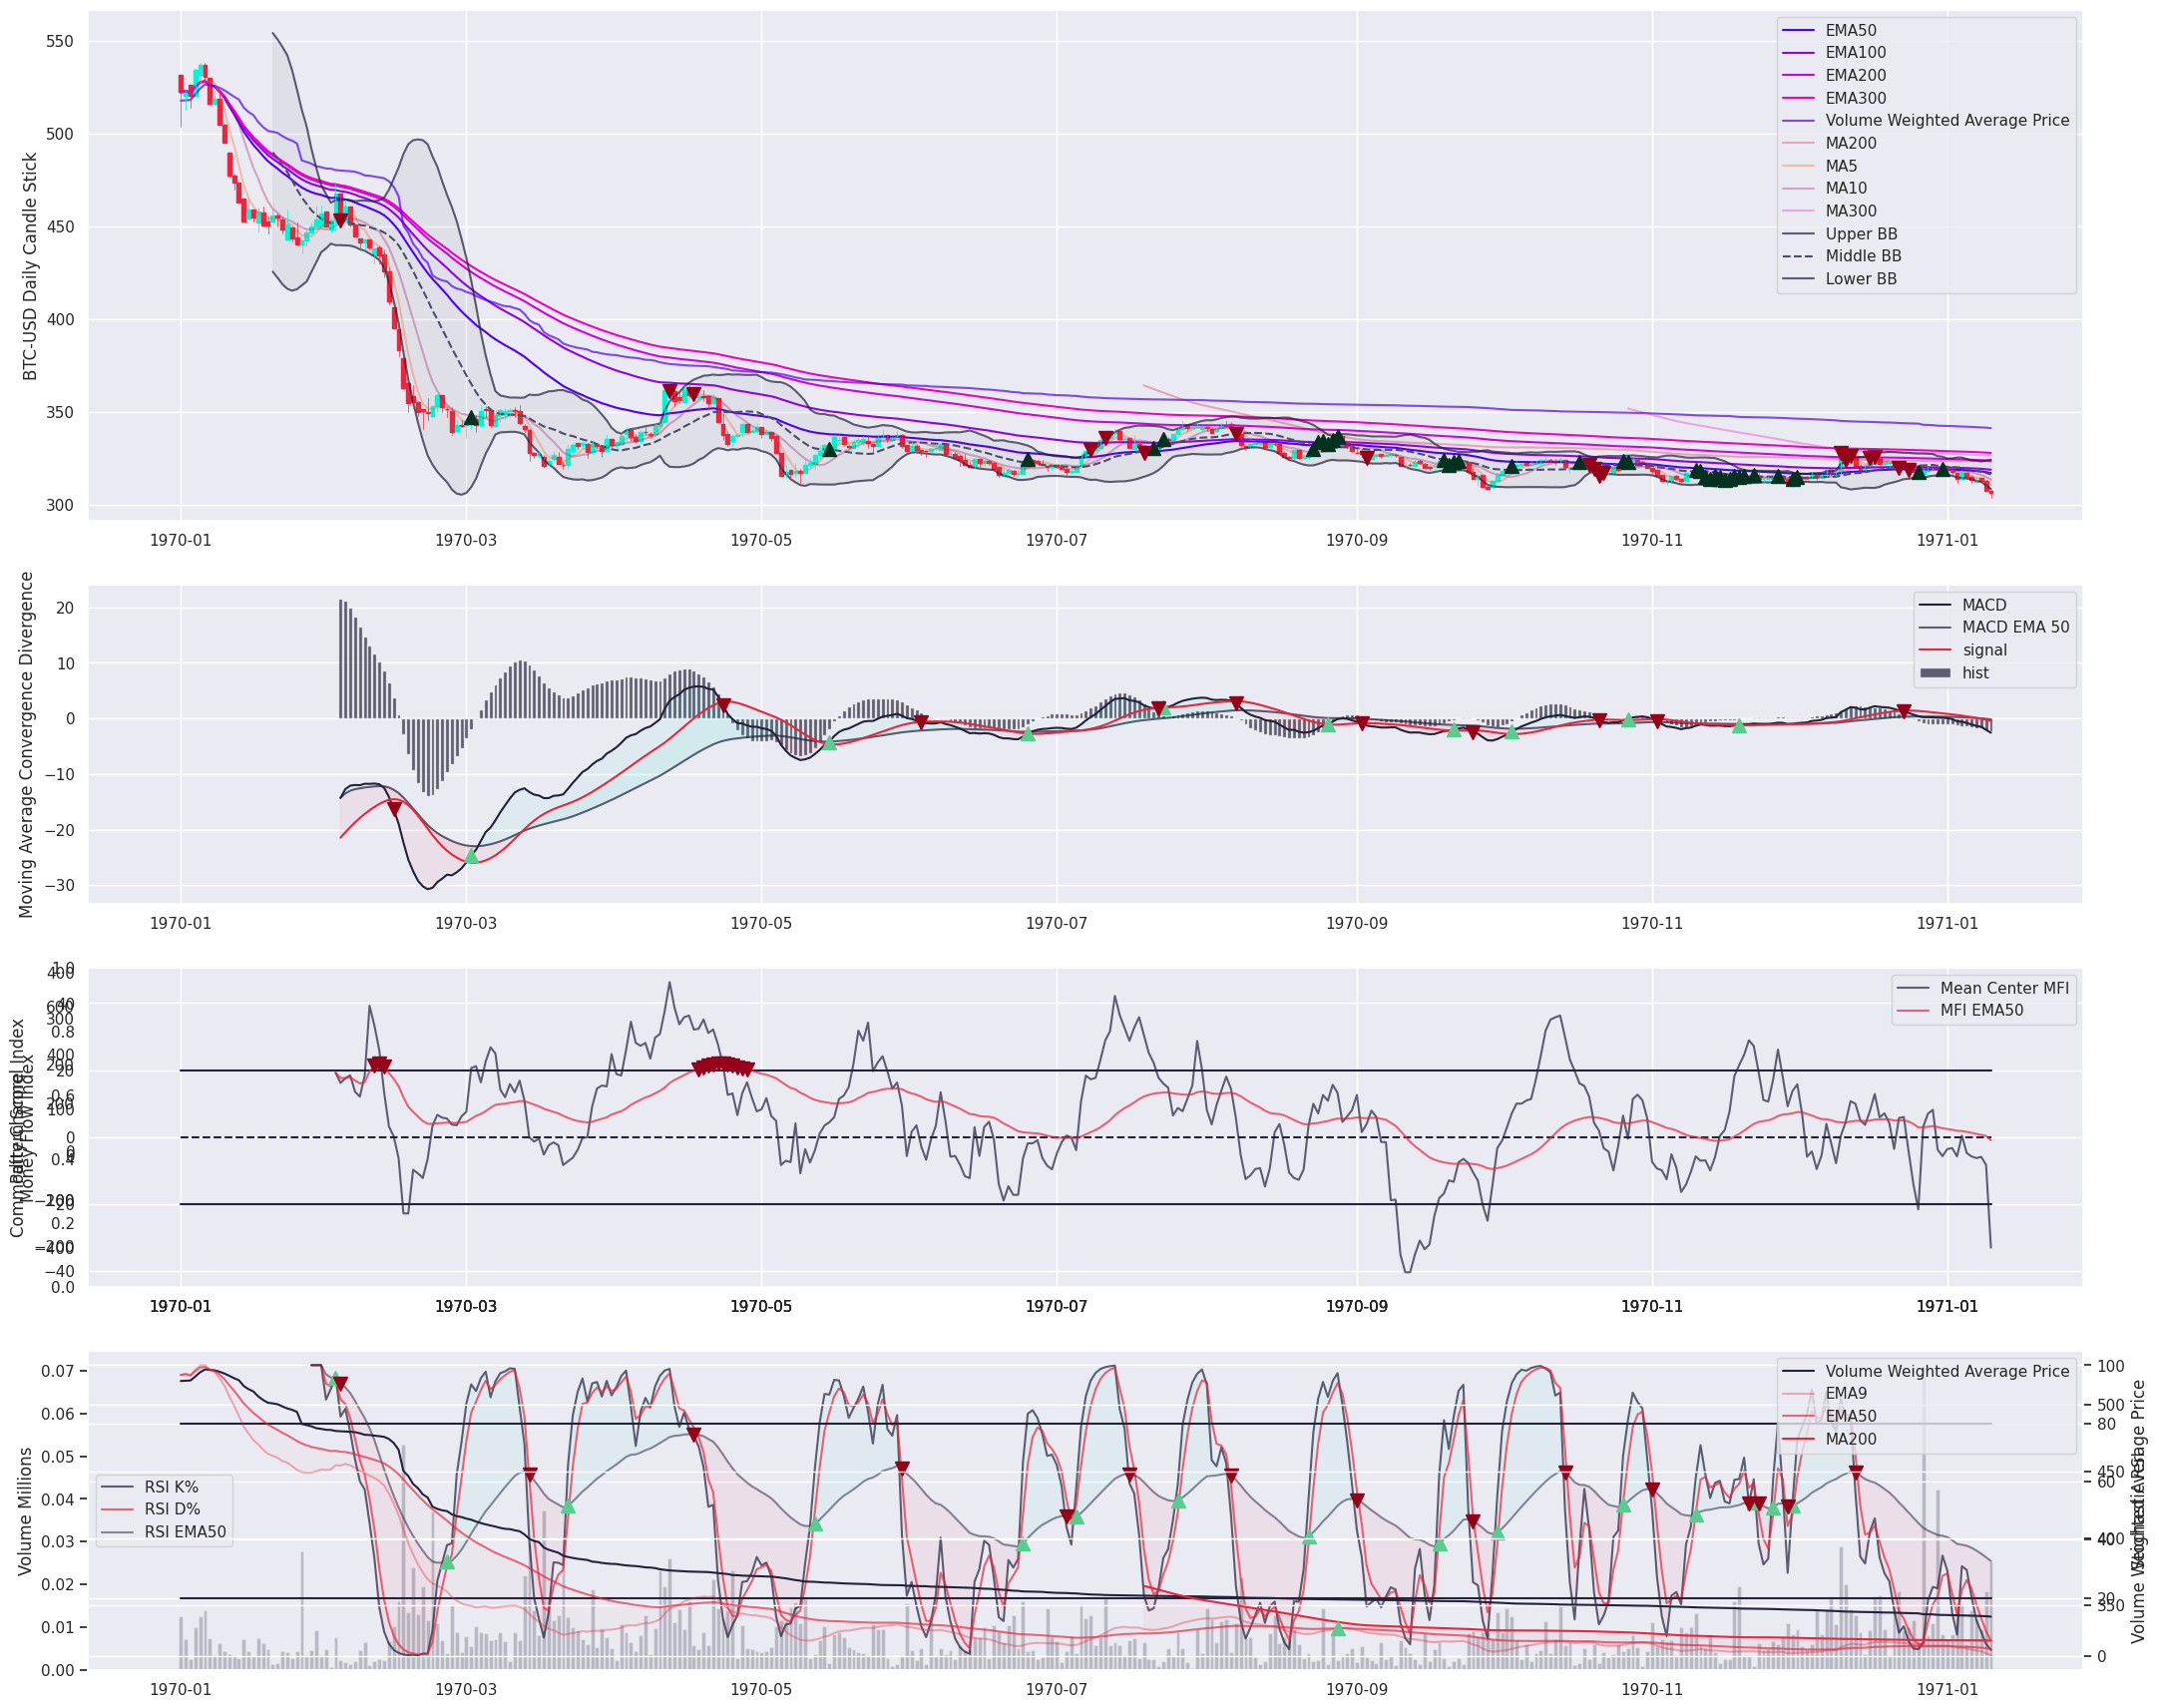

In [ ]:
#dummmy direct Test

DF_Sample =pd.read_csv('/content/sample_data_B.csv')

print(DF_Sample)


import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

expiry_date="2024-11-13"
right_action="CALL"
strike_price="52000"
stock_code="CNXBAN"
exchange_code='NFO'
from_date= "2024-11-07T09:00:00.000Z"
to_date= "2024-11-07T16:55:00.000Z"
product_type="options"
PreviousPivotDate=''
OrderID=0

stock_code="CNXBAN"


#%pdb off
result=Execute('CNXBAN',app,from_date,to_date,stock_code,strike_price)
if result is not None:
  # PreviousPivotDate=(result.PreviousPivotDate)
  # OrderID=result.orderId
  print("result"+str(result))


In [ ]:
#dummmy realtime Test

# import json


# datafilter = pd.read_csv('Sample.csv')
# data=datafilter.loc[lambda x: x['last'].between(0, 1500)]
# data.head()

DF_Sample =pd.read_csv('/content/sample_data_B.csv')

print(DF_Sample)

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

expiry_date="2024-11-06"
right_action="call"
strike_price="52000"
stock_code="CNXBAN"
exchange_code='NFO'
from_date= "2024-10-31T09:00:00.000Z"
to_date= "2024-10-31T16:55:00.000Z"
product_type="options"
PreviousPivotDate=''
OrderID=0
#Log(datetime.datetime.strptime(from_date.split('T')[0], '%Y-%m-%d'))


fhdata = app.get_historical_data_v2(interval="1minute",
                                from_date= str(from_date),
                                to_date= str(to_date),
                                stock_code=str(stock_code),
                                exchange_code=str(exchange_code),
                                product_type=str(product_type),
                                expiry_date=str(expiry_date),
                                right=str(right_action),
                                strike_price=str(strike_price))
#print(fhdata)
df_test = pd.json_normalize(fhdata['Success'])
data_test = get_indicators(df_test)

# def Execute(ticks,app,from_date,to_date,stock_code):
#     return GetData(ticks,app,from_date,to_date,stock_code)
PreviousPivotDate=''
#datetime.datetime.now() - datetime.timedelta(minutes=1)
OrderID=0
i=0



for index, row in data_test.iterrows():
  i=i+1
  if(i>15):
    clear_output(wait=False)
    i=0
  #print(dateutil.parser.parse(row['datetime']).strftime("%Y-%m-%dT%H:%M:%S")+".000Z")
  stock_code="CNXBAN"
  from_date= "2024-10-31T09:00:00.000Z"
  #to_date="2024-06-07T09:30:00.000Z"
  to_date= str(dateutil.parser.parse(row['datetime']).strftime("%Y-%m-%dT%H:%M:%S")+".000Z")
  print(to_date)
  product_type="Options"
  #%pdb off
  result=Execute('CNXBAN',app,from_date,to_date,stock_code,strike_price)
  if result is not None:
    # PreviousPivotDate=(result.PreviousPivotDate)
    # OrderID=result.orderId
    print("result"+str(result))
    #time.sleep(15)


{'interval': '1minute', 'exchange_code': 'NFO', 'stock_code': 'NIFTY', 'expiry_date': '14-Nov-2024', 'strike_price': '24100.0', 'right_type': 'CE', 'low': '246.6', 'high': '250.75', 'open': '246.6', 'close': '249.35', 'volume': '15650', 'oi': '763200', 'datetime': '2024-11-07 15:23:00'}
NIFTY
2024-11-07 15:23:00
{'interval': '1minute', 'exchange_code': 'NFO', 'stock_code': 'NIFTY', 'expiry_date': '14-Nov-2024', 'strike_price': '24100.0', 'right_type': 'CE', 'low': '246.6', 'high': '250.75', 'open': '246.6', 'close': '249.35', 'volume': '15650', 'oi': '763200', 'datetime': '2024-11-07 15:23:00'}
NIFTY
2024-11-07 15:23:00
NIFTY
2024-11-07T09:00:00.000Z
2024-11-07T16:55:00.000Z
NIFTY
24100.0
24100.0


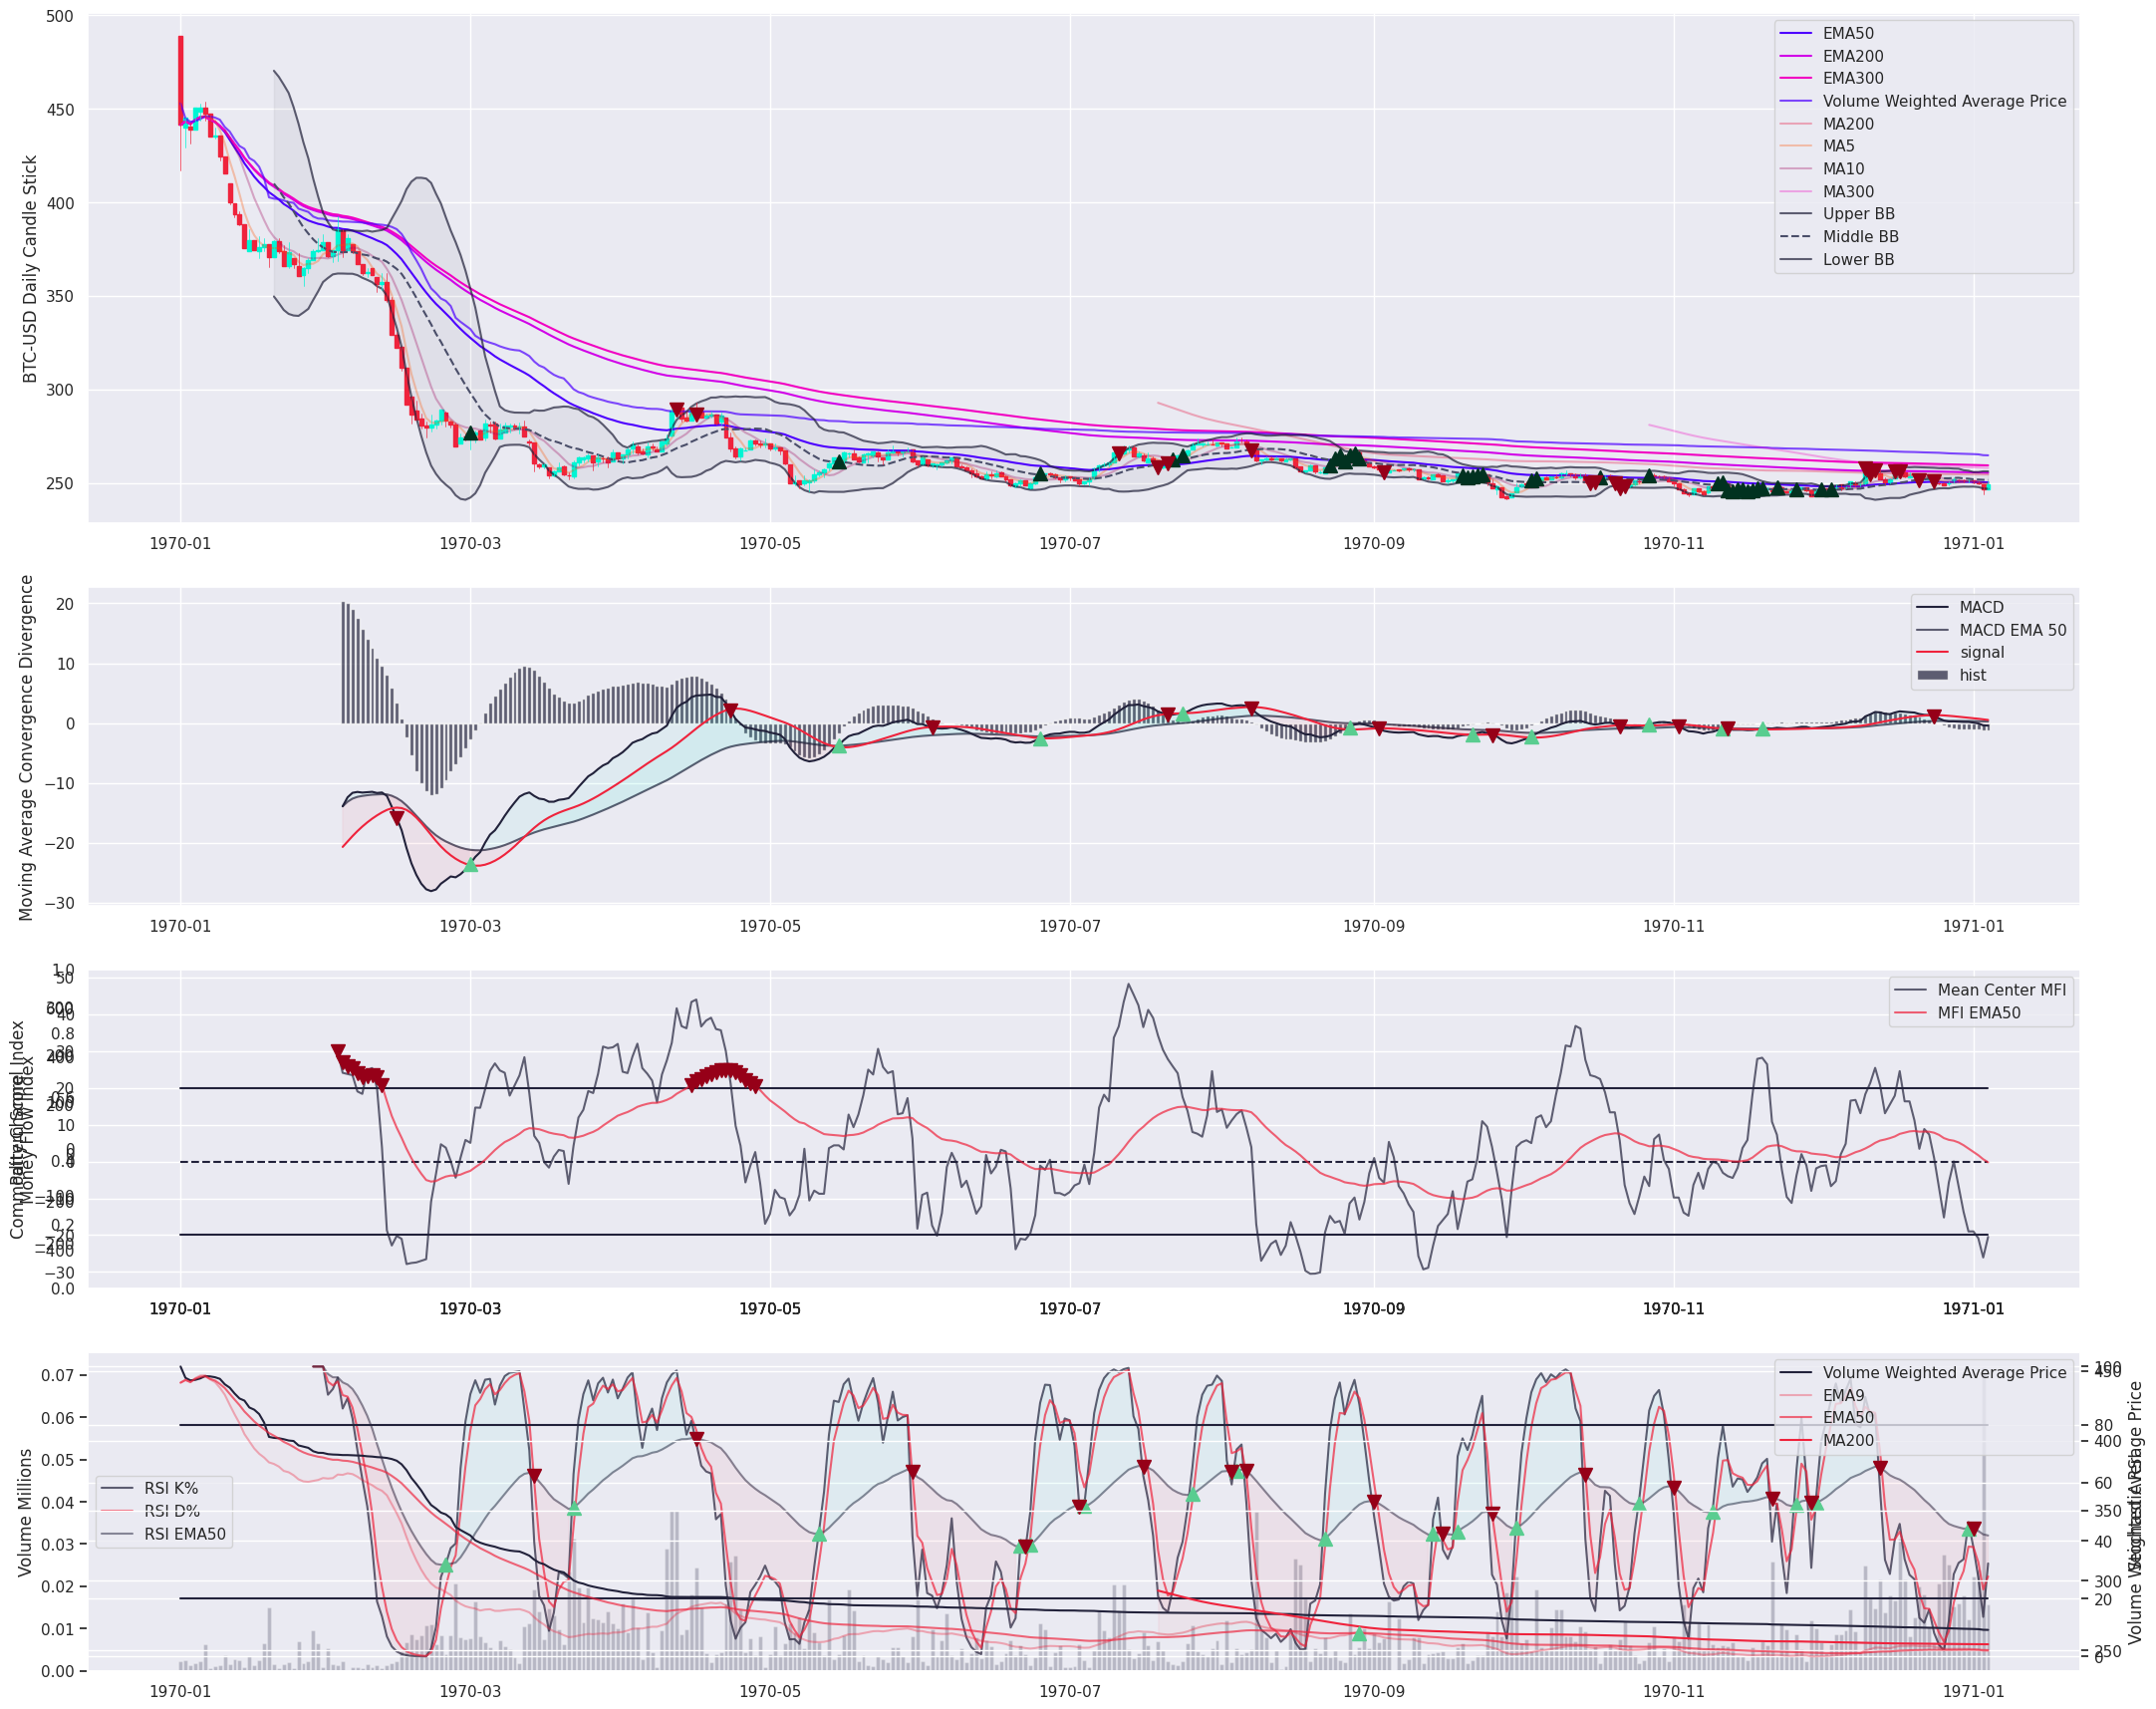

In [ ]:




import json
from pytz import timezone
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

api_key = "6N4Hj74vE@668970816zP9K307YZ58Ff"
api_secret = "iz1F27815220!290Ie8Ha459997J8376"
api_session = '48938079'
app = BreezeConnect(api_key=api_key)
app.generate_session(api_secret=api_secret,
                     session_token=api_session)
clear_output(wait=False)
from_date= from_date
to_date= to_date
SavingFilenames=datetime.datetime.strptime(from_date.split('T')[0], '%Y-%m-%d')





import threading
import queue
import _thread
import json
from multiprocessing import Process
DF_Sample =pd.read_csv('/content/sample_data.csv')
print(DF_Sample)

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
from_date= from_date
to_date= to_date

options_basket = [
    {"stock_code": "NIFTY", "expiry_date": "14-Nov-2024", "strike_price": "24300", "right": "Call","expiry_date_str":"2024-11-06"},
]

# ticks_queue = queue.Queue()

last_price_tick = None
last_price_tick_lock = threading.Lock()
ticks_queue = queue.Queue()


def store_ticks(ticks):
             print(ticks)

             json_dat = json.dumps(ticks)
             dict_dat = json.loads(json_dat)
             print(dict_dat['stock_code'])
             print(dict_dat['datetime'])
             result=Execute(dict_dat['stock_code'],app,from_date,to_date,dict_dat['stock_code'],dict_dat["strike_price"])
             #y = json.loads(str(ticks))

             #print("Ticks: {}".format(ticks))
             #print(y[0])

             #df = pd.DataFrame(ticks)
             #latest_tick = df.iloc[-1].to_dict()
             #print(latest_tick["stock_code"])
             #result=Execute(latest_tick["stock_code"],app,from_date,to_date,latest_tick["stock_code"],latest_tick["strike_price"])
    # code to store tick into database

# Callback to receive ticks and put them in the queue

# Function to continuously process ticks and save them into a DataFrame
# def process_ticks():
#     global last_price_tick
#     while running:
#         ticks = []
#         while not ticks_queue.empty():
#             ticks.append(ticks_queue.get())
#         if ticks:
#              print(1)
#              df = pd.DataFrame(ticks)
#              latest_tick = df.iloc[-1].to_dict()
#              result=Execute(latest_tick["stock_code"],app,from_date,to_date,latest_tick["stock_code"])


# # Start a separate thread for continuous processing
# ticks_thread = threading.Thread(target=process_ticks, daemon=True)
# ticks_thread.start()

def on_ticks(ticks):
             clear_output(wait=False)
             print(ticks)
             json_dat = json.dumps(ticks)
             dict_dat = json.loads(json_dat)
             print(dict_dat['stock_code'])
             print(dict_dat['datetime'])
             p = Process(target=store_ticks, args=(ticks,))
             p.start()
             p.join()
             #result=Execute(dict_dat['stock_code'],app,from_date,to_date,dict_dat['stock_code'],dict_dat["strike_price"])
             #threading.Thread(target=store_ticks, args=(ticks,),daemon=True).start()
           # _thread.start_new_thread(store_ticks, (ticks,))
            #  print(ticks)
            #  json_dat = json.dumps(ticks)
            #  dict_dat = json.loads(json_dat)
            #  print(dict_dat['stock_code'])
            #  print(dict_dat['datetime'])
            #  json_dat = json.dumps(ticks)
            #  dict_dat = json.loads(json_dat)
            #  print(dict_dat['stock_code'])
            # result=Execute(dict_dat['stock_code'],app,from_date,to_date,dict_dat['stock_code'],dict_dat["strike_price"])
       #print(ticks)

       #latest_tick = df.iloc[-1].to_dict()
      #  _thread.start_new_thread(store_ticks, (ticks,))
      #  ticks_thread = threading.Thread(target=process_ticks,args=(arg1, arg2=arg2), daemon=True)
      #  ticks_thread.start()
      #print(latest_tick["stock_code"])
       #result=Execute(latest_tick["stock_code"],app,from_date,to_date,latest_tick["stock_code"])
      #  ticks_queue.put(ticks)
      # print(ticks)
      # stock_code="NIFTY"
      # from_date= "2024-10-0T09:00:00.000Z"
      # to_date="2024-10-04T016:30:00.000Z"
      # #to_date= str(dateutil.parser.parse(row['datetime']).strftime("%Y-%m-%dT%H:%M:%S")+".000Z")
      # #print(to_date)
      # product_type="Options"
      # #%pdb off
      # result=Execute('NIFTY',app,from_date,to_date,stock_code)
    # ticks_queue.put(ticks)

# Assign the callbacks
app.on_ticks = on_ticks
# app.subscribe_feeds(get_order_notification=True)
running = True

# Function to continuously process ticks and save them into a DataFrame


# Connect to the websocket
app.ws_disconnect()
app.ws_connect()


for option in options_basket:

    dict_current_quote = app.get_quotes(stock_code=str(option["stock_code"]),exchange_code='NFO',product_type='options',right='Others',
                                        expiry_date=str(option["expiry_date"]).replace(' ',''),strike_price='0')['Success'][0]
    #print(dict_current_quote)
    currentstrick=round_down(float(dict_current_quote['spot_price']),100)
    #print(currentstrick)
    print(app.subscribe_feeds(exchange_code="NFO",
                           stock_code=option["stock_code"],
                           product_type="options",
                           expiry_date=str(option["expiry_date"]),#option["expiry_date"],
                           strike_price=str(int(currentstrick)),
                           right=option["right"],
                           interval="1minute"

                        ))

time.sleep(30000000)

# while(True):
#  time.sleep(3)
#  t=1+1


In [ ]:
import json
from pytz import timezone
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

expiry_date="2024-06-13"
right_action="CALL"
strike_price="22800"
stock_code="NIFTY"
exchange_code='NFO'
from_date= "2024-06-07T09:00:00.000Z"
to_date= "2024-06-07T16:55:00.000Z"
product_type="Options"
PreviousPivotDate='' #datetime.datetime.now() - datetime.timedelta(minutes=1)
OrderID=0


def Execute(app,from_date,to_date,stock_code,exchange_code,product_type,expiry_date,right_action,strike_price,PreviousPivotDate,OrderID):
    #print("Execute() Previous Date "+ str(PreviousPivotDate) + "Order id" + str(OrderID) )
    return GetData(app,from_date,to_date,stock_code,exchange_code,product_type,expiry_date,right_action,strike_price,PreviousPivotDate,OrderID)

result=Execute(app,from_date,to_date,stock_code,exchange_code,product_type,expiry_date,right_action,strike_price,PreviousPivotDate,OrderID)
if result is not None:
        PreviousPivotDate=(result.PreviousPivotDate)
        OrderID=result.orderId
        print("result"+str(result))
        #time.sleep(15)


TypeError: GetData() missing 1 required positional argument: 'OrderID'

In [ ]:

# ticks = ['BTC-AUD','LTC-BTC', 'ETH-BTC', 'BCH-BTC', 'XRP-BTC']
# ticks = ['ETH-BTC','LINK-BTC','BNB-BTC','XRP-BTC',
#          'ADA-BTC','BCH-BTC','EOS-BTC','VET-BTC','BAT-BTC',
#          'LTC-BTC','ZEC-BTC','TRX-BTC','XMR-BTC','XLM-BTC',
#          'NEO-BTC','ETC-BTC','ZRX-BTC','BNT-BTC','KNC-BTC',
#          'QTUM-BTC','RLC-BTC','DASH-BTC','LRC-BTC','XVG-BTC',
#          'DGB-BTC','SC-BTC','FUN-BTC','MIOTA-BTC','ICX-BTC',
#          'NANO-BTC','MCO-BTC','KMD-BTC','ARDR-BTC','REP-BTC',
#          'STRAT-BTC','ARK-BTC','BTS-BTC','WAVES-BTC',
#          'MTL-BTC','WTC-BTC','CVC-BTC','XEM-BTC','XZC-BTC']

ticks = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'BCH-USD', 'XRP-USD', 'EOS-USD']
# ticks = ['BTC-AUD']
# ticks = ['ETH-BTC','LINK-BTC','BNB-BTC','XRP-BTC']
# ticks = ['APT.AX','Z1P.AX','AMD', 'INTC', 'NFLX', 'TSLA']

# BIG BOYS
# ticks = ['AAPL', 'FB', 'MSFT', 'AMZN', 'AMD', 'INTC', 'NFLX', 'TSLA']
# ticks = ['SPY']
# ticks = [ '^GSPC', '^DJI', '^IXIC', '^AXJO']

# COMMSEC ETF TICKS
# ticks = ['IOZ.AX', 'NDQ.AX', 'IOO.AX', 'IEM.AX', 'SYI.AX', 'IXJ.AX','ETHI.AX' ]

# MAKING DATAFRAME
yf.pdr_override()
for tick in ticks:
  data = pdr.get_data_yahoo(tick, interval = '1d', period = "3y")
  print('*********************',tick,'*********************')
  data = get_indicators(data)
  data['macd_buy_signal'] = data.apply(macd_buy_signal, axis=1)
  data['macd_sell_signal'] = data.apply(macd_sell_signal, axis=1)
  # data['CCI_buy_signal'] = data.apply(cci_buy_signal, axis=1)
  # data['CCI_sell_signal'] = data.apply(cci_sell_signal, axis=1)
  data['MFI_buy_signal'] = data.apply(MFI_buy_signal, axis=1)
  data['MFI_sell_signal'] = data.apply(MFI_sell_signal, axis=1)
  # data['VWAP_buy_signal'] = data.apply(vwap_buy_signal, axis=1)
  # data['VWAP_sell_signal'] = data.apply(vwap_sell_signal, axis=1)
  data['RSI_buy_signal'] = data.apply(rsi_buy_signal, axis=1)
  data['RSI_sell_signal'] = data.apply(rsi_sell_signal, axis=1)
  data = patterns(data)
  data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
  data['Sell_Signal'] = data.apply(sell_conditions, axis=1)
  # I recommend the time frame looked at is approx ~250 days or less to best visualise the the markers (60 days for stocks)
  plot_chart(data, len(data)-180,len(data), tick) # data,min_date_len, max_date_len, tick   len(data)-250

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: YFInvalidPeriodError("%ticker%: Period '3y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']")


********************* BTC-USD *********************


TypeError: money_flow_index() got an unexpected keyword argument 'n'

# Evnironment to Test Strategy

In [ ]:

def trade_env(data, tick, print_ = True):
  CAPITAL = 100 # units
  COMMISSION = 0.01
  units = 0

  def neat_date(x):
    return str(x).replace("00:00:00","")

  for i in range(len(data)):

    if (data.Buy_Signal[i] > 0) and (CAPITAL > 0) and (data.Buy_Signal[i] < data.middleband[i]): # Buy 20 when under the middleband
      units = units + (20/data.Buy_Signal[i])*(1-COMMISSION) # How much to buy - commisson
      CAPITAL = CAPITAL - 20
      # if (print_ == True):
      #   print(f'{neat_date(data.index[i])} : BUY {20/data.Buy_Signal[i]} at {data.Buy_Signal[i]}')

    if (data.Buy_Signal[i] > 0) and (CAPITAL > 0) and (data.Buy_Signal[i] > data.middleband[i]): # Buy 10 when over the middleband
      units = units + (10/data.Buy_Signal[i])*(1-COMMISSION) # How much to buy - commisson
      CAPITAL = CAPITAL - 10
      # if (print_ == True):
      #   print(f'{neat_date(data.index[i])} : BUY {10/data.Buy_Signal[i]} at {data.Buy_Signal[i]}')


    if (units > 0):
      if (data.Sell_Signal[i] > 0): # Sell
        sell_units = 10/data.Sell_Signal[i]
        CAPITAL = CAPITAL + ((data.Sell_Signal[i]*(sell_units))*(1-COMMISSION)) # sellign 50 percent everytime - commisson
        # if (print_ == True):
        #   print(f'{neat_date(data.index[i])} : SELL {units} at {data.Sell_Signal[i]}')
        units = units-sell_units

    if (i == (data.shape[0]-1)): # Print portfolio value of last day
      portfolio_val = (units*data.Close[i]) + CAPITAL # Current portfolio value
      print(f'{neat_date(data.index[i])} : APPROX {tick} PORTFOLIO VALUE {portfolio_val}')

  return portfolio_val
ticks = ['ETH-BTC','LINK-BTC','BNB-BTC',
         'ADA-BTC','BCH-BTC','EOS-BTC','VET-BTC','BAT-BTC',
         'LTC-BTC','ZEC-BTC','TRX-BTC','XMR-BTC','XLM-BTC',
         'NEO-BTC','ETC-BTC','ZRX-BTC','BNT-BTC','KNC-BTC',
         'QTUM-BTC','RLC-BTC','DASH-BTC','LRC-BTC','XVG-BTC',
         'DGB-BTC','SC-BTC','FUN-BTC','MIOTA-BTC','ICX-BTC',
         'NANO-BTC','MCO-BTC','KMD-BTC','ARDR-BTC','REP-BTC',
         'STRAT-BTC','ARK-BTC','BTS-BTC','WAVES-BTC',
         'MTL-BTC','CVC-BTC','XEM-BTC','XZC-BTC']
# ticks = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'BCH-USD', 'XRP-USD', 'EOS-USD']
# ticks = ['AAPL', 'FB', 'MSFT', 'AMZN', 'AMD', 'INTC', 'NFLX', 'TSLA']
portval = []
for tick in ticks:
  data = pdr.get_data_yahoo(tick, interval = '1d', period = "2y")
  print('*********************',tick,'*********************')
  data = get_indicators(data)
  data = patterns(data)
  data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
  data['Sell_Signal'] = data.apply(sell_conditions, axis=1)
  val = trade_env(data,tick)
  portval.append(val)

  """
  """

TypeError: YahooDailyReader.__init__() got an unexpected keyword argument 'period'

In [ ]:
def Average(lst):
    return sum(lst) / len(lst)
Average(portval)

105.71111762830898

Code to make a make a gif

In [ ]:

# # ticks = ['BTC-AUD','LTC-BTC', 'ETH-BTC', 'BCH-BTC', 'XRP-BTC']
# # ticks = ['ETH-BTC','LINK-BTC','BNB-BTC','XRP-BTC',
# #          'ADA-BTC','BCH-BTC','EOS-BTC','VET-BTC','BAT-BTC',
# #          'LTC-BTC','ZEC-BTC','TRX-BTC','XMR-BTC','XLM-BTC',
# #          'NEO-BTC','ETC-BTC','ZRX-BTC','BNT-BTC','KNC-BTC',
# #          'QTUM-BTC','RLC-BTC','DASH-BTC','LRC-BTC','XVG-BTC',
# #          'DGB-BTC','SC-BTC','FUN-BTC','MIOTA-BTC','ICX-BTC',
# #          'NANO-BTC','MCO-BTC','KMD-BTC','ARDR-BTC','REP-BTC',
# #          'STRAT-BTC','ARK-BTC','BTS-BTC','WAVES-BTC',
# #          'MTL-BTC','WTC-BTC','CVC-BTC','XEM-BTC','XZC-BTC']

# ticks = ['ETH-USD']
# # ticks = ['BTC-USD']
# # ticks = ['APT.AX','Z1P.AX','AMD', 'INTC', 'NFLX', 'TSLA']

# # ticks = ['AAPL', 'FB', 'MSFT', 'AMZN', 'AMD', 'INTC', 'NFLX', 'TSLA']
# ticks = ['INTC']

# # ticks = [ '^GSPC', '^DJI', '^IXIC', '^AXJO']

# # MAKING DATAFRAME
# yf.pdr_override()
# for tick in ticks:
#   data = pdr.get_data_yahoo(tick, interval = '1d', period = "4y")
#   print('*********************',tick,'*********************')
#   data = get_indicators(data)
#   data['macd_buy_signal'] = data.apply(macd_buy_signal, axis=1)
#   data['macd_sell_signal'] = data.apply(macd_sell_signal, axis=1)
#   # data['CCI_buy_signal'] = data.apply(cci_buy_signal, axis=1)
#   # data['CCI_sell_signal'] = data.apply(cci_sell_signal, axis=1)
#   data['MFI_buy_signal'] = data.apply(MFI_buy_signal, axis=1)
#   data['MFI_sell_signal'] = data.apply(MFI_sell_signal, axis=1)
#   data['RSI_buy_signal'] = data.apply(rsi_buy_signal, axis=1)
#   data['RSI_sell_signal'] = data.apply(rsi_sell_signal, axis=1)
#   # data = patterns(data)
#   data['Buy_Signal'] = data.apply(buy_conditions, axis=1)
#   data['Sell_Signal'] = data.apply(sell_conditions, axis=1)
#   # I recommend the time frame looked at is approx ~250 days or less to best visualise the the markers (60 days for stocks)
#   for i in np.arange(560,700,14): #1080
#     plot_chart(data, 300 + i,480+i,i, tick) # data,min_date_len, max_date_len, tick   len(data)-250